In [ ]:
import numpy as np
import pandas as pd

# Import tools needed for visualization
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydot
import pydotplus
from sklearn.tree import export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt

# Models & Processing
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score

# Tuning of Model
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

# Imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

In [ ]:
df = pd.read_csv('https://github.com/tzekiattok/strokedata/blob/main/healthcare-dataset-stroke-data.csv?raw=true')

There is 201 missing value from bmi column. As missing data may led to bias and inaccuracy in results, hence there is a need to handle it. 

In [ ]:
df.info()
#let stroke the the label, (0,1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Remove 'id' column because it is unique and has no meaningful contribution to the model results.

In [ ]:
df.drop('id', axis=1, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 1. Impute missing values (BMI) with Decision Tree Regressor

The decision tree regressor will analyze the age, gender and bmi of other observations and use that information to predict the value of  the missing bmi based on the age and  gender of the observation.

In [ ]:
DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=0))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

### 2. OneHotEncode + Label Encoding Categorical values

*   Label Encoding - Categorical data with binary response
*   One Hot Encode - Categorical data with more than two types of response

In [ ]:
if df['ever_married'].dtype == type(object):
    le = preprocessing.LabelEncoder()
    df['ever_married'] = le.fit_transform(df['ever_married'])
    
if df['Residence_type'].dtype == type(object):
    le = preprocessing.LabelEncoder()
    df['Residence_type'] = le.fit_transform(df['Residence_type'])
        
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,1,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,1,Self-employed,0,202.21,29.879487,never smoked,1
2,Male,80.0,0,1,1,Private,0,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,1,Private,1,171.23,34.400000,smokes,1
4,Female,79.0,1,0,1,Self-employed,0,174.12,24.000000,never smoked,1


In [ ]:
#Encode values
df_encoded = df
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['gender'], prefix = 'gender=')], axis = 1).drop(['gender'], axis = 1)
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['work_type'], prefix = 'work_type=')], axis = 1).drop(['work_type'], axis = 1)
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['smoking_status'], prefix = 'smoking_status=')], axis = 1).drop(['smoking_status'], axis = 1)
df1 = df_encoded
df_encoded.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender=_Female,gender=_Male,gender=_Other,work_type=_Govt_job,work_type=_Never_worked,work_type=_Private,work_type=_Self-employed,work_type=_children,smoking_status=_Unknown,smoking_status=_formerly smoked,smoking_status=_never smoked,smoking_status=_smokes
0,67.0,0,1,1,1,228.69,36.600000,1,0,1,0,0,0,1,0,0,0,1,0,0
1,61.0,0,0,1,0,202.21,29.879487,1,1,0,0,0,0,0,1,0,0,0,1,0
2,80.0,0,1,1,0,105.92,32.500000,1,0,1,0,0,0,1,0,0,0,0,1,0
3,49.0,0,0,1,1,171.23,34.400000,1,1,0,0,0,0,1,0,0,0,0,0,1
4,79.0,1,0,1,0,174.12,24.000000,1,1,0,0,0,0,0,1,0,0,0,1,0


### 3. Define X & y

*   y - target variable - stroke 



In [ ]:
X = df1[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'ever_married', 'work_type=_Govt_job','work_type=_Never_worked','work_type=_Private','work_type=_Self-employed','work_type=_children','Residence_type','smoking_status=_Unknown','smoking_status=_formerly smoked','smoking_status=_never smoked','smoking_status=_smokes','gender=_Female','gender=_Male', 'gender=_Other']]
y = df1['stroke']
Columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'ever_married', 'work_type=_Govt_job','work_type=_Never_worked','work_type=_Private','work_type=_Self-employed','work_type=_children','Residence_type','smoking_status=_Unknown','smoking_status=_formerly smoked','smoking_status=_never smoked','smoking_status=_smokes','gender=_Female','gender=_Male', 'gender=_Other']

### 4. Train Test Split

*   Use random state=424 to get a standardise results across the different machine learning models
*   Use test size = 0.2 (Commonly split 80-20 for train-test data)
*   Standardise data for variables such as 'avg_glucose_level' that has a different scale from the other variables


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=424)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### 5. Outlier Removal

*   Remove outliers so that it will not affect the results when performing analysis on random forest

In [ ]:
iso = IsolationForest(contamination=0.1, random_state=424)
yhat = iso.fit_predict(X_train_scaled)

In [ ]:
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train_scaled[mask], y_train[mask]

In [ ]:
print(X_train.shape, y_train.shape)

(3679, 19) (3679,)


### 6. Apply Random Oversampling

*   Apply Random Oversampling only to train data to see how well the model performs in real world using imbalance test data

In [ ]:
rforest = RandomForestClassifier(random_state=424)

In [ ]:
def evaluate_model(X_train, y_train, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    diff = scores.mean() - model.score(X_test, y_test)
    SD = diff / scores.std()
    
    print(f"Training Score:{model.score(X_train, y_train)}")
    print(f"Cross V Score: {scores.mean()} +/- {scores.std()}")
    print(f"Testing Score: {model.score(X_test, y_test)}")
    print(f"Cross & Test Diff: {diff}")
    print(f"Standard Deviations Away: {SD}")
    print(confusion_matrix(y_test, preds))

In [ ]:
evaluate_model(X_train, y_train, rforest)

Training Score:1.0
Cross V Score: 0.9600434841762713 +/- 1.5355175701934546e-05
Testing Score: 0.9481409001956947
Cross & Test Diff: 0.011902583980576531
Standard Deviations Away: 775.1512722239294
[[969   0]
 [ 53   0]]


In [ ]:
ros = RandomOverSampler(random_state=424)

# fit predictor and target variable
X_train_ros, y_train_ros =  ros.fit_resample(X_train, y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_ros))

Original dataset shape Counter({0: 3535, 1: 144})
Resample dataset shape Counter({0: 3535, 1: 3535})


In [ ]:
evaluate_model(X_train_ros, y_train_ros, rforest)

Training Score:1.0
Cross V Score: 0.990664420230507 +/- 0.001930967125811143
Testing Score: 0.9452054794520548
Cross & Test Diff: 0.04545894077845225
Standard Deviations Away: 23.54205836588558
[[964   5]
 [ 51   2]]


### 7. Apply PCA

*   To validate if PCA is meaningful in the analysis of model for this dataset
*   Apply PCA to all 19 columns (components) and find the appropriate number of columns that meets 95% cumulative variance ratio.


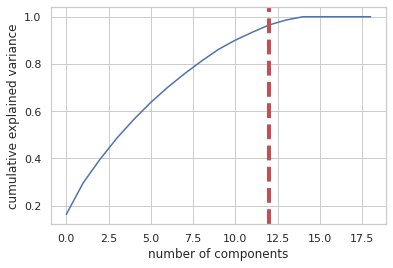

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.162772,0.162772
1,0.296509,0.133737
2,0.396638,0.100129
3,0.486665,0.090028
4,0.565693,0.079028
5,0.637456,0.071763
6,0.701260,0.063804
7,0.759188,0.057928
8,0.812382,0.053193
9,0.861772,0.049391


In [ ]:
pca_test = PCA(n_components=19)
pca_test.fit(X_train_ros)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=12, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(14))

In [ ]:
# View top variables
pca = PCA(n_components=12)
pca.fit(X_train_ros)

X_train_ros = pca.transform(X_train_ros)
X_test = pca.transform(X_test)

In [ ]:
# View correlation of PCA features
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=Columns, index=pca_dims)
pca_test_df.head(14).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8,PCA Component 9,PCA Component 10,PCA Component 11,PCA Component 12,PCA Component 13
age,-0.464645,0.116266,0.081874,0.035284,0.038374,-0.035945,0.032949,0.054400,0.068119,-0.470373,-0.235157,0.084239,-0.084190,0.409267
hypertension,-0.191433,-0.086433,0.004767,-0.224842,-0.225988,0.017701,-0.199692,-0.158779,0.862007,0.100055,0.115353,0.026357,0.121860,0.039681
heart_disease,-0.023080,0.122904,-0.032917,-0.126233,0.164048,-0.042036,0.017739,-0.057368,-0.070991,-0.142022,-0.327063,0.073198,0.871128,0.026007
avg_glucose_level,-0.225162,0.066440,-0.028019,0.001006,-0.136030,0.714158,-0.131720,0.479123,-0.032919,0.255689,-0.298374,0.016813,-0.021523,0.018785
bmi,-0.252675,0.146742,-0.072695,0.019776,-0.009854,0.151044,0.060465,0.151684,-0.149042,0.097143,0.803053,-0.066740,0.350901,0.055058
ever_married,-0.384820,0.145097,0.007423,0.066739,0.061188,0.038802,-0.003240,-0.033324,0.038614,-0.349441,0.004354,-0.004916,-0.071808,-0.829552
work_type=_Govt_job,-0.059291,-0.171186,0.083663,0.143090,0.147445,0.446099,0.540403,-0.430807,0.071650,-0.093671,0.049394,-0.017371,-0.028358,0.113162
work_type=_Never_worked,0.034200,-0.020525,0.017792,-0.020592,-0.010157,-0.010200,0.036099,0.005164,-0.033234,0.116901,0.069017,0.978383,-0.018824,-0.081914
work_type=_Private,-0.082563,0.348643,-0.535566,-0.211786,-0.202636,-0.203434,-0.049257,0.064580,-0.076084,-0.028089,-0.025252,-0.023120,-0.124211,0.079947
work_type=_Self-employed,-0.186456,-0.194683,0.569219,0.116353,0.203206,-0.217525,-0.342920,0.265625,-0.046038,-0.015219,0.104032,-0.014700,0.007930,0.084441


### Fit into the model (Random Forest)

*   Train the model
*   Identify the accuracy, precision, recall, f1_score and ROC AUC score for the base model


In [ ]:
rforest = RandomForestClassifier(random_state=424)
rforest.fit(X_train_ros,y_train_ros)
y_pred = rforest.predict(X_test)

conf_matrix_rf = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred) 
recall = metrics.recall_score(y_test, y_pred) 
f1_score = metrics.f1_score(y_test, y_pred) 

accuracies = cross_val_score(estimator = rforest, X = X_train_ros, y = y_train_ros, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score

print(conf_matrix_rf, '\n Accuracy:',
      accuracy,'\n Precision:',  precision,'\n Recall:',  recall,'\n f1_score:',  f1_score,'\n Kfold validation:',accuracies,'\n ROC AUC Score:',roc)

[[958  11]
 [ 51   2]] 
 Accuracy: 0.9393346379647749 
 Precision: 0.15384615384615385 
 Recall: 0.03773584905660377 
 f1_score: 0.06060606060606061 
 Kfold validation: [0.99575672 0.98727016 0.99434229 0.99292786 0.99575672 0.99717115
 0.99575672 0.99292786 0.99292786 0.99151344] 
 ROC AUC Score: 0.5131919699359386


In [ ]:
evaluate_model(X_train_ros, y_train_ros, rforest)

Training Score:1.0
Cross V Score: 0.9895331585838424 +/- 0.0011143582878170816
Testing Score: 0.9393346379647749
Cross & Test Diff: 0.05019852061906749
Standard Deviations Away: 45.04702048512733
[[958  11]
 [ 51   2]]


### Tuning hyperparams with GridsearchCV
Find the most optimal parameters that will output the best roc_auc scores.
*   To not overfit the model, use max_depth between 5-8 (commonly used range)

In [ ]:
rf_model = [(
    RandomForestClassifier(),
    [{'n_estimators':[100,200],
      'max_depth':[5, 8],
      'max_features': [8,10,12],
      'criterion':['gini','entropy'],
      'n_jobs':[-1], 'random_state':[424]}])]

In [ ]:
for i,j in rf_model:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring = 'roc_auc',cv = 10)
    grid.fit(X_train_ros, y_train_ros)
    best_param = grid.best_params_
    print('Best Parameters : ',best_param)
    print('')
    print('----------------')
    print('')

Best Parameters :  {'criterion': 'gini', 'max_depth': 8, 'max_features': 8, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 424}

----------------



Accuracy: 0.7886497064579256 
 Precision: 0.11737089201877934 
 Recall: 0.4716981132075472 
 f1_score: 0.18796992481203006 

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       969
           1       0.12      0.47      0.19        53

    accuracy                           0.79      1022
   macro avg       0.54      0.64      0.53      1022
weighted avg       0.92      0.79      0.84      1022

ROC AUC score: 0.7506669003251748
Accuracy Score:  0.7886497064579256
Balanced Accuracy Score:  0.6388418326615651


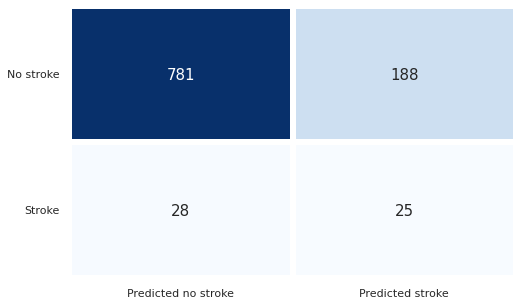

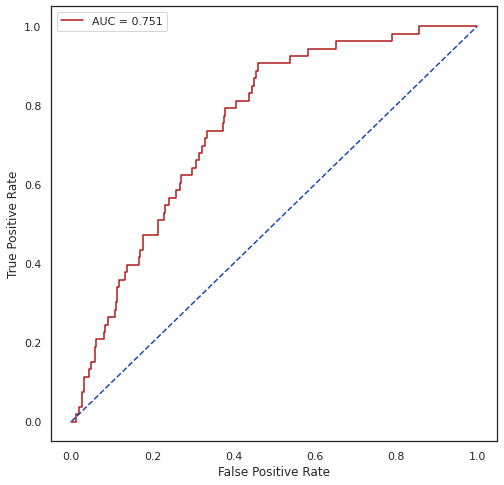

In [ ]:
# Display results with hyperparameterized model

rforest = RandomForestClassifier(criterion='gini', max_depth=8, max_features=8, n_estimators=200, n_jobs=-1, random_state=424)
rforest.fit(X_train_ros,y_train_ros)

y_pred = rforest.predict(X_test)
y_prob = rforest.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred) 
recall = metrics.recall_score(y_test, y_pred) 
f1_score = metrics.f1_score(y_test, y_pred) 
print('Accuracy:',
      accuracy,'\n Precision:',  precision,'\n Recall:',  recall,'\n f1_score:',  f1_score, '\n')

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('Balanced Accuracy Score: ',balanced_accuracy_score(y_test, y_pred))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc AUC Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()